In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance
import shap

In [2]:
# Read in Storm Prediction Center tornado dataset.
tor = pd.read_csv("https://www.spc.noaa.gov/wcm/data/1950-2021_actual_tornadoes.csv")
tor

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,192,1950,10,1,1950-10-01,21:00:00,3,OK,40,23,...,15.80,10,1,1,1,25,0,0,0,0
1,193,1950,10,9,1950-10-09,02:15:00,3,NC,37,9,...,2.00,880,1,1,1,47,0,0,0,0
2,195,1950,11,20,1950-11-20,02:20:00,3,KY,21,1,...,0.10,10,1,1,1,177,0,0,0,0
3,196,1950,11,20,1950-11-20,04:00:00,3,KY,21,2,...,0.10,10,1,1,1,209,0,0,0,0
4,197,1950,11,20,1950-11-20,07:30:00,3,MS,28,14,...,2.00,37,1,1,1,101,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67553,620523,2021,9,8,2021-09-08,15:32:00,3,PA,42,0,...,0.73,30,1,1,1,109,0,0,0,0
67554,620524,2021,9,8,2021-09-08,15:35:00,3,PA,42,0,...,1.45,30,1,1,1,109,0,0,0,0
67555,620525,2021,9,8,2021-09-08,19:08:00,3,FL,12,0,...,1.45,50,1,1,1,129,0,0,0,0
67556,620526,2021,9,9,2021-09-09,02:10:00,3,CT,9,0,...,0.75,75,1,1,1,13,0,0,0,0


In [3]:
# Get tornadoes that occured in Illinois
tor_ill = tor[tor["st"] == "IL"].copy()
tor_ill

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
6,198,1950,12,2,1950-12-02,15:00:00,3,IL,17,7,...,18.80,50,1,1,1,119,117,0,0,0
7,199,1950,12,2,1950-12-02,16:00:00,3,IL,17,8,...,18.00,200,1,1,1,119,5,0,0,0
9,201,1950,12,2,1950-12-02,17:30:00,3,IL,17,9,...,9.60,50,1,1,1,157,0,0,0,0
12,6,1950,1,25,1950-01-25,21:00:00,3,IL,17,3,...,0.10,100,1,1,1,91,0,0,0,0
15,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,2,...,3.60,130,1,1,1,135,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67519,620382,2021,8,9,2021-08-09,17:26:00,3,IL,17,0,...,0.20,20,1,1,1,37,0,0,0,0
67520,620383,2021,8,9,2021-08-09,17:28:00,3,IL,17,0,...,3.90,400,1,1,1,89,0,0,0,0
67521,620384,2021,8,9,2021-08-09,17:38:00,3,IL,17,0,...,0.10,10,1,1,1,89,0,0,0,0
67522,620385,2021,8,9,2021-08-09,17:57:00,3,IL,17,0,...,3.00,525,1,1,1,11,0,0,0,0


In [4]:
# Aggregate the tornado data over Illinois into a monthly count of tornadoes.
tor_ill["date"] = pd.to_datetime(tor_ill["date"])
tor_ill_monthly = (
    tor_ill.groupby(tor_ill["date"].dt.to_period("M")).size().reset_index(name="count")
)
tor_ill_monthly = tor_ill_monthly.set_index("date")
tor_ill_monthly = tor_ill_monthly.to_timestamp()
tor_ill_monthly

,count
date,
1950-01-01,2
1950-03-01,1
1950-06-01,1
1950-07-01,1
1950-12-01,3
...,...
2021-06-01,15
2021-07-01,8
2021-08-01,16


In [5]:
# Read in ENSO, PDO, NAO, and AO dataframe created in Module 4 Notebook 1.
clim_ind = pd.read_csv("climate_indices.csv")
clim_ind["Date"] = pd.to_datetime(clim_ind["Date"])
clim_ind = clim_ind.set_index("Date")
clim_ind

,ENSO,PDO,NAO,AO
Date,,,,
1951-01-01,1.5,-1.19,0.08,-0.085
1951-02-01,0.9,-1.52,0.70,-0.400
1951-03-01,-0.1,-1.72,-1.02,-1.934
1951-04-01,-0.3,-1.35,-0.22,-0.776
1951-05-01,-0.7,-1.29,-0.59,-0.863
...,...,...,...,...
2025-08-01,0.4,-3.20,0.26,0.036
2025-09-01,0.0,-2.33,-0.80,0.048
2025-10-01,NaN,-2.40,-0.96,0.064


In [6]:
# Merge Illinois monthly count tornado data with climate indice data
df = tor_ill_monthly.merge(clim_ind, how="inner", left_index=True, right_index=True)
df

,count,ENSO,PDO,NAO,AO
1951-06-01,2,0.2,-1.77,-1.64,-0.918
1951-11-01,2,-0.8,-0.31,-0.39,-0.069
1951-12-01,1,-0.7,-1.45,1.32,1.987
1952-03-01,2,0.5,-1.67,-1.49,-1.859
1952-05-01,1,0.8,-2.07,-1.12,-0.774
...,...,...,...,...,...
2021-06-01,15,0.4,-1.82,0.77,0.845
2021-07-01,8,1.4,-2.00,0.03,0.630
2021-08-01,16,0.6,-0.95,-0.28,-0.209
2021-10-01,10,0.7,-3.13,-2.29,-0.146


In [7]:
# Split data for training and testing.
X = df[["ENSO", "PDO", "NAO", "AO"]]
y = df["count"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (308, 4) Test size: (132, 4)


In [8]:
# Create a Random Forest Regression model and parameter grid.
forest = RandomForestRegressor(random_state=42)

param_grid_rfr = {
    "bootstrap": [True, False],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "max_features": ["auto", "sqrt"],
    "min_samples_leaf": [1, 2, 4],
    "min_samples_split": [2, 5, 10],
    "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
}

grid_rfr = GridSearchCV(forest, param_grid_rfr, cv=7, n_jobs=-1)

In [9]:
# Run a grid search to find the best parameters.
grid_rfr.fit(X_train, y_train)

grid_rfr.best_params_

/opt/anaconda3/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py:516: FitFailedWarning: 
13860 fits failed out of a total of 27720.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
6391 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 600}

In [10]:
# Fit the best model on the training data.
model_rfr = grid_rfr.best_estimator_
model_rfr.fit(X_train, y_train)

,n_estimators,600
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,4
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [11]:
# Predict monthly count of tornadoes using the testing data.
y_pred_rfr = model_rfr.predict(X_test)

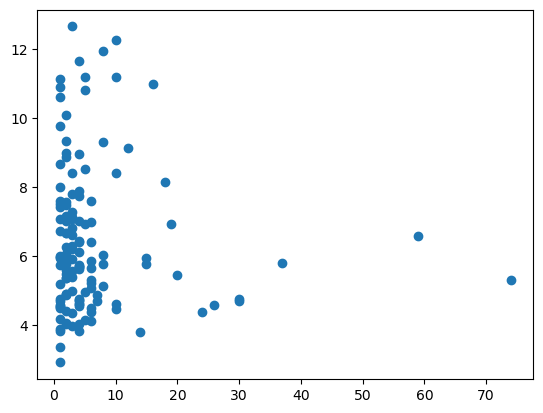

In [12]:
# Create a scatter plot of the predicted and observed number of tornadoes.
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred_rfr)

In [13]:
# Report the correlation coefficient and RMSE of the random forest regression model.
print("R^2 of the Random Forest Regression model:", r2_score(y_test, y_pred_rfr))

print(
    "RMSE of the Random Forest Regression model:",
    root_mean_squared_error(y_test, y_pred_rfr),
)

R^2 of the Random Forest Regression model: -0.06839610190485823
RMSE of the Random Forest Regression model: 10.071242979995471


The resulting R^2 and RMSE of our random forest regression model indicates that our model does not perform very well.
Now we will try using one-hot encoding for month of the year and adding as features in the regeression model. 

In [14]:
# Get month of year for each row.
df["moy"] = df.index.month
df["moy"]

1951-06-01     6
1951-11-01    11
1951-12-01    12
1952-03-01     3
1952-05-01     5
              ..
2021-06-01     6
2021-07-01     7
2021-08-01     8
2021-10-01    10
2021-12-01    12
Name: moy, Length: 440, dtype: int32

In [15]:
# Create a column for each month of the year using one-hot encoding.
enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(df[["moy"]])
enc.categories_
moy = enc.transform(df[["moy"]]).toarray()
months = [
    "January",
    "February",
    "March",
    "April",
    "May",
    "June",
    "July",
    "August",
    "September",
    "October",
    "November",
    "December",
]
moy = pd.DataFrame(moy, columns=months)
moy.index = df.index
moy

,January,February,March,April,May,June,July,August,September,October,November,December
1951-06-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1951-11-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1951-12-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1952-03-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1952-05-01,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-01,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-08-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [16]:
# Add month of year array to the dataframe.
df_ohe = pd.concat([df, moy], axis=1)
df_ohe = df_ohe.drop("moy", axis=1)
df_ohe

,count,ENSO,PDO,NAO,AO,January,February,March,April,May,June,July,August,September,October,November,December
1951-06-01,2,0.2,-1.77,-1.64,-0.918,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1951-11-01,2,-0.8,-0.31,-0.39,-0.069,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1951-12-01,1,-0.7,-1.45,1.32,1.987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1952-03-01,2,0.5,-1.67,-1.49,-1.859,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1952-05-01,1,0.8,-2.07,-1.12,-0.774,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-01,15,0.4,-1.82,0.77,0.845,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2021-07-01,8,1.4,-2.00,0.03,0.630,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2021-08-01,16,0.6,-0.95,-0.28,-0.209,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2021-10-01,10,0.7,-3.13,-2.29,-0.146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [17]:
# Split data for training and testing.
X2 = df_ohe[
    [
        "ENSO",
        "PDO",
        "NAO",
        "AO",
        "January",
        "February",
        "March",
        "April",
        "May",
        "June",
        "July",
        "August",
        "September",
        "October",
        "November",
        "December",
    ]
]
y2 = df_ohe["count"]

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42
)
print("Train size:", X2_train.shape, "Test size:", X2_test.shape)

Train size: (330, 16) Test size: (110, 16)


In [18]:
# Fit the model on the training data and predict tornado count using the testing data.
model_rfr.fit(X2_train, y2_train)

y2_pred_rfr = model_rfr.predict(X2_test)

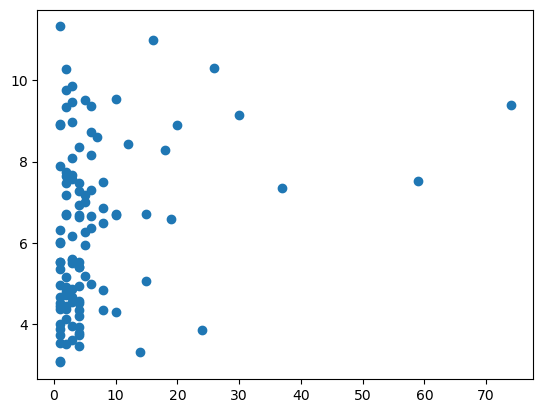

In [19]:
# Create a scatter plot of the predicted and observed number of tornadoes.
fig, ax = plt.subplots()
ax.scatter(y2_test, y2_pred_rfr)

In [20]:
# Report the correlation coefficient and RMSE of the random forest regression model.
print("R^2 of the Random Forest Regression model:", r2_score(y2_test, y2_pred_rfr))

print(
    "RMSE of the Random Forest Regression model:",
    root_mean_squared_error(y2_test, y2_pred_rfr),
)

R^2 of the Random Forest Regression model: 0.06820463127456367
RMSE of the Random Forest Regression model: 9.940665060520388


Adding month of the year as a feature in the regression model slightly improved the outcome with a slightly better R^2 and RMSE value, but overall the model still does not perform very well.

In [21]:
# Perform a feature importance and multipass permutation analysis of your features.
mdi_importances = pd.Series(
    model_rfr[-1].feature_importances_, index=X2.columns
).sort_values(ascending=True)

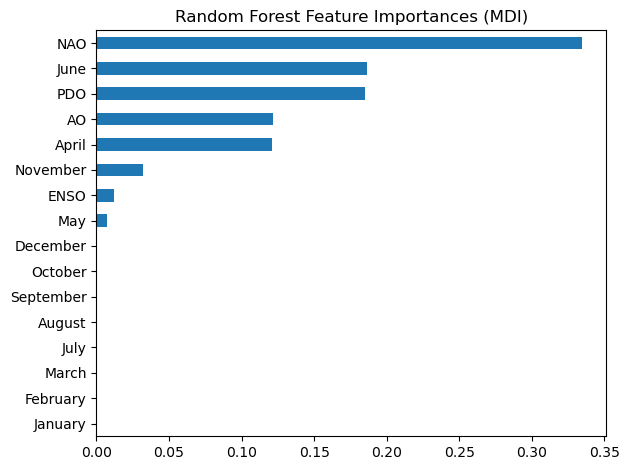

In [22]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

Using feature importance based on mean decrease in impurity we can see that our climate indices along with the Spring months: April, May, June are our most important features along with the month of November.

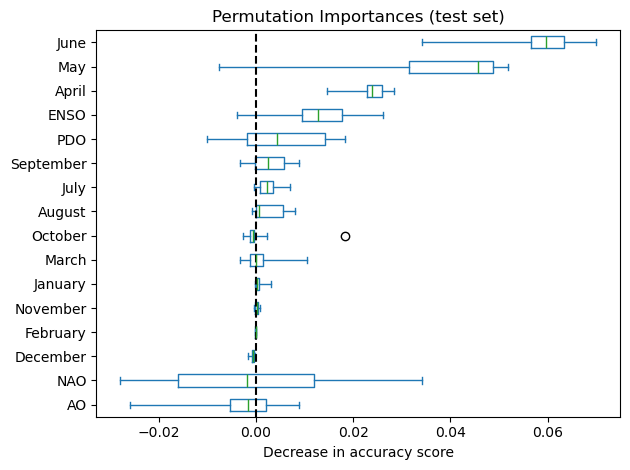

In [23]:
result = permutation_importance(
    model_rfr, X2_test, y2_test, n_repeats=10, random_state=42, n_jobs=-1
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X2.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (test set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

Using permutation importance the most important features turn out to be our spring months, April, May, and June followed by ENSO. Meaning those features contribute most to the overall performance of the model.

In [24]:
# Find shap values of our model.
shap.initjs()

explainer = shap.Explainer(model_rfr, X2_train, feature_names=X2.columns)
shap_values = explainer(X2_test, check_additivity=False)  # shap.Explanation
shap_values

.values =
array([[-0.34153621, -0.25932882, -0.43835472, ...,  0.05494721,
         0.00162186, -0.05519183],
       [ 0.18851534,  0.14559649, -0.7064706 , ...,  0.04460886,
         0.00194614, -0.04554203],
       [-0.14633868, -0.05865377,  0.12327616, ...,  0.07468143,
         0.00312111,  0.68105204],
       ...,
       [-0.03793347, -0.09346123, -0.00533631, ...,  0.07804134,
         0.00346072, -0.02646571],
       [-0.039582  , -0.60568587,  0.18444761, ...,  0.07460125,
         0.00420924, -0.03792755],
       [-0.29488164, -0.10524414,  0.47499813, ...,  0.07386364,
        -0.09276764, -0.04489875]], shape=(110, 16))

.base_values =
array([6.12196009, 6.12196009, 6.12196009, 6.12196009, 6.12196009,
       6.12196009, 6.12196009, 6.12196009, 6.12196009, 6.12196009,
       6.12196009, 6.12196009, 6.12196009, 6.12196009, 6.12196009,
       6.12196009, 6.12196009, 6.12196009, 6.12196009, 6.12196009,
       6.12196009, 6.12196009, 6.12196009, 6.12196009, 6.12196009,
       6.

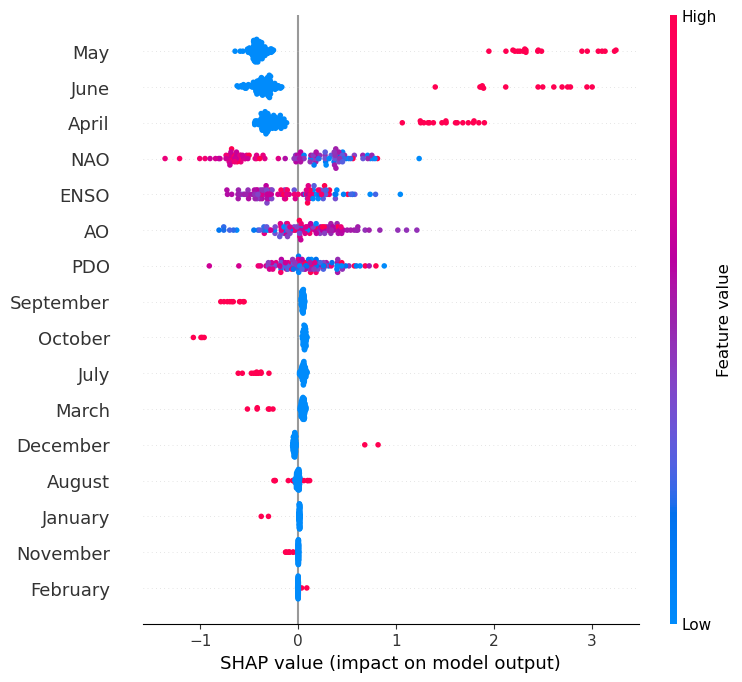

In [25]:
# Create a SHAP Summary Plot showing feature importance and feature effects.
shap.plots.beeswarm(shap_values, max_display=17)

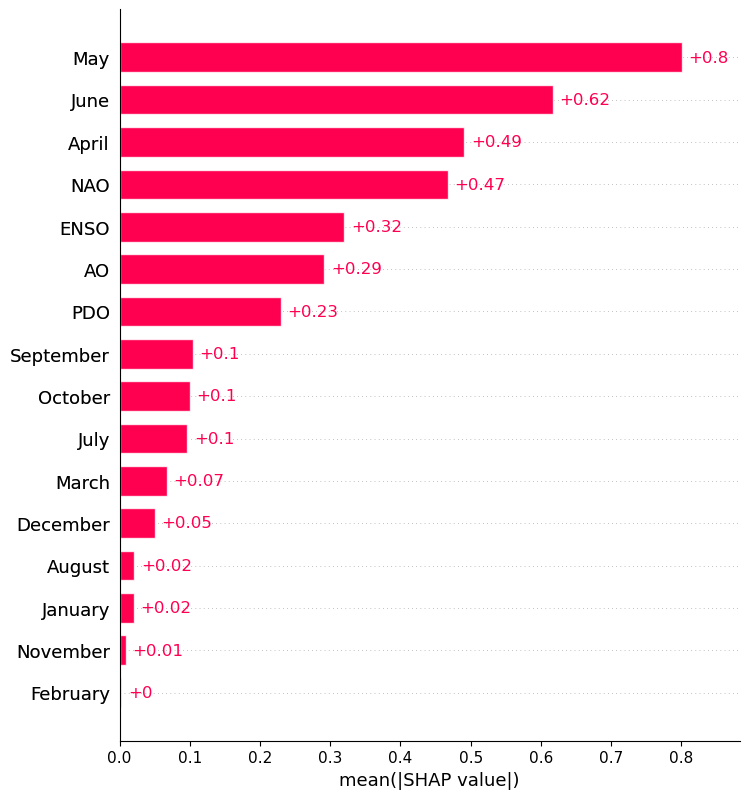

In [26]:
shap.plots.bar(shap_values, max_display=17)

The SHAP analysis shows again that the months of April, May, and June have the largest impact on our model, particularly for high counts of tornadoes. This makes sense physically because those months are peak tornado season for the Midwest including Illinois due to warm moist air orginating from the Gulf moving northward and combining with cool air moving southward from Canada.

The next features with the largest impact are the climate indices. This makes sense since those features impact global climate and weather patterns.

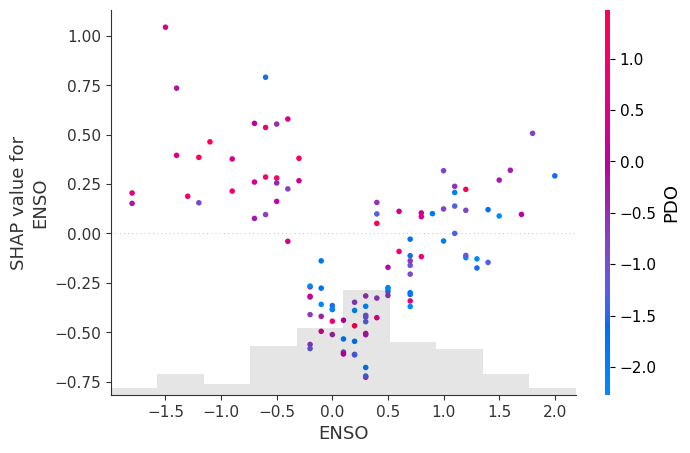

In [27]:
# Create a SHAP Feature Dependence for the ENSO index.
shap.plots.scatter(shap_values[:, 'ENSO'], color=shap_values)

Interestingly ENSO is most impactful as a feature during its positive and negative phases but is less impactful when neutral. When ENSO is in positive or negative phase it has impacts on climate patterns in the midwest US that could be favorable or unfavorable towards tornado production.

Overall our models show that using climate indices as a predictor for tornado rate is overall difficult to do seasonally. From observations and feature importance analysis we can see that the Spring months favor tornado production in the Midwest and are therefore the most important and impactful features for our model.